<a href="https://colab.research.google.com/github/Sigma1084/MA4340_Heston_Model/blob/master/Heston_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [1]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import random

## CIR Process

In [2]:
np.random.seed(seed=678)

N = 500001        # time steps 
paths = 200      # number of paths 
T = 3
T_vec, dt = np.linspace(0,T,N, retstep=True )

# standard parameters
kappa = 4
theta = 2
sigma = 0.5
std_asy = np.sqrt( theta * sigma**2 /(2*kappa) )   # asymptotic standard deviation

X0 = 2.5
X = np.zeros((paths,N))
X[:,0] = X0
W = ss.norm.rvs( loc=0, scale=np.sqrt(dt), size=(paths,N-1) )

for t in range(0,N-1):
    X[:,t+1] = np.abs( X[:,t] + kappa*(theta - X[:,t])*dt + sigma * np.sqrt(X[:,t]) * W[:,t] )

X_T = X[:,-1]    # values of X at time T
X_1 = X[1,:]     # a single path


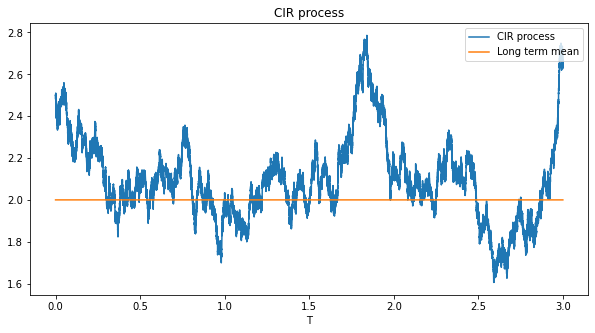

In [3]:
plt.figure(figsize=(10,5))
plt.plot(T_vec, X_1, label="CIR process")
plt.plot(T_vec, theta*np.ones_like(T_vec), label="Long term mean")
plt.legend(loc="upper right")
plt.title("CIR process")
plt.xlabel("T")
plt.show()

## Heston Model

In [4]:
def heston_price(S_0, K, V_0, kappa, theta, sigma, rho, T):
    """
    Calculates the Option Price using Heston model
    
    :param S_0: Initial Stock Prince
    :param K: Strike Price
    :param V_0: Initial Variance is square of Volatility
    :param kappa: Mean Reversion Speed
    :param theta: Long-run Variance
    :param sigma: Volatility of volatility
    :param rho: Correlation
    :param T: Time to Maturity
    :return: Option Price
    """

    random.seed(5000) # Set the random seed
    N = 10**2         # Number of small sub-steps (time)
    n = 10**4         # Number of Monte carlo paths
    dt = T/N          # No. of Time step

    # Integrate equations: Euler method, Montecarlo vectorized
    V_t = np.ones(n) * V_0
    S_t = np.ones(n) * S_0

    # Generate Montecarlo paths
    for t in range(1, N):
        # Random numbers for S_t and V_t
        Z_s = np.random.normal(size=n)
        Z_v = rho * Z_s + np.sqrt(1 - rho**2) * np.random.normal(size=n)

        # Euler integration
        V_t = np.maximum(V_t, 0)
        S_t = S_t * np.exp( np.sqrt(V_t * dt) * Z_s - V_t * dt / 2)                     # Stock price process
        V_t = V_t + kappa * (theta - V_t) * dt + sigma * np.sqrt(V_t * dt) * Z_v        # Volatility process

    option_price = np.mean(np.maximum(S_t - K, 0))
    return round(option_price,2)

heston_vectorized = np.vectorize(heston_price)

In [5]:
S_0 = 17339         # Initial Stock Price
K = 16100           # Strike Price
V_0 = 0.01          # Initial volatility
kappa = 2           # kappa
theta = 0.01        # theta
eps = 0.1           # epsilon
rho = 0             # correlation co-efficient
T = 7/12            # time period

V = heston_price(S_0, K, V_0, kappa, theta, eps, rho, T)
print(V)

1348.71


In [6]:
rhos = np.linspace(-1, 1, 20)
option_prices = heston_vectorized(S_0, K, V_0, kappa, theta, eps, rhos, T)
print(option_prices)

mean_opt = np.mean(option_prices)
print("Mean Option Price:", mean_opt)
print("Root Mean Squared Error:", np.sqrt(np.average(np.square(option_prices-mean_opt))))

[1364.9  1368.59 1378.3  1369.87 1365.61 1356.37 1352.22 1374.97 1355.87
 1342.88 1350.79 1339.5  1327.13 1327.24 1315.08 1324.65 1331.43 1297.61
 1307.76 1289.4 ]
Mean Option Price: 1342.0085000000001
Root Mean Squared Error: 25.538153080244445


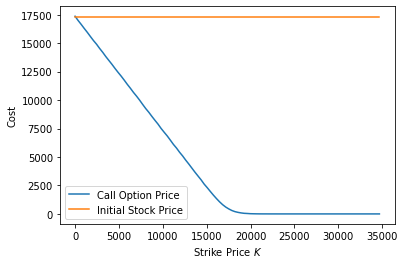

In [7]:
strike_prices = np.linspace(0, 2*S_0, 100)
plt.xlabel("Strike Price $K$")
plt.ylabel("Cost")
plt.plot(strike_prices, heston_vectorized(S_0, strike_prices, 
    V_0, kappa, theta, eps, rho, T), label="Call Option Price")
plt.plot(strike_prices, [S_0 for _ in strike_prices], label="Initial Stock Price")
plt.legend()
plt.show()